In [4]:
import numpy as np
import seaborn as sns
import pandas.util.testing as tm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [51]:
df=pd.read_csv("/content/drive/My Drive/dataset/books.csv",error_bad_lines=False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'



Columns Description:
- bookID Contains the unique ID for each book/series
- title contains the titles of the books
- authors contains the author of the particular book
- average_rating the average rating of the books, as decided by the users
- ISBN ISBN(10) number, tells the information about a book - such as edition and publisher
- ISBN 13 The new format for ISBN, implemented in 2007. 13 digits
- language_code Tells the language for the books
- Num_pages Contains the number of pages for the book
- Ratings_count Contains the number of ratings given for the book
- text_reviews_count Has the count of reviews left by users


In [52]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [64]:
df.replace(to_replace='J.K. Rowling/Mary GrandPré', value = 'J.K. Rowling', inplace=True)

In [54]:
len(df)

11123

In [9]:
df.isnull().any()

bookID                False
title                 False
authors               False
average_rating        False
isbn                  False
isbn13                False
language_code         False
  num_pages           False
ratings_count         False
text_reviews_count    False
publication_date      False
publisher             False
dtype: bool

In [11]:
del df['isbn']
del df['isbn13']

In [ ]:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

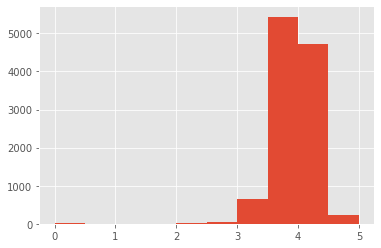

In [55]:
df['average_rating'].hist()

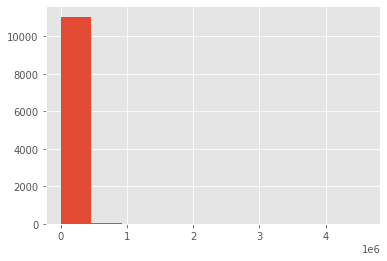

In [56]:
df["ratings_count"].hist()

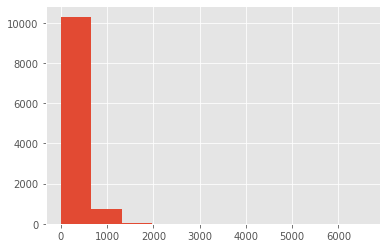

In [57]:
df['  num_pages'].hist()

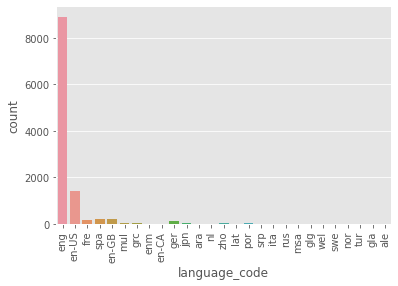

In [58]:
ax=sns.countplot(x="language_code", data=df)
ax=ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

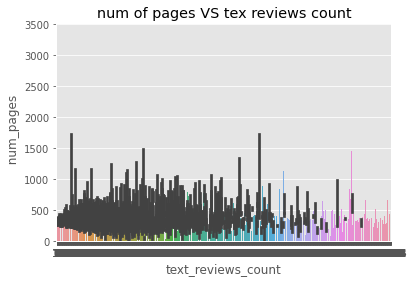

In [59]:
sns.barplot(x="text_reviews_count", y="  num_pages", data=df)
plt.title('num of pages VS text reviews count')
plt.show()

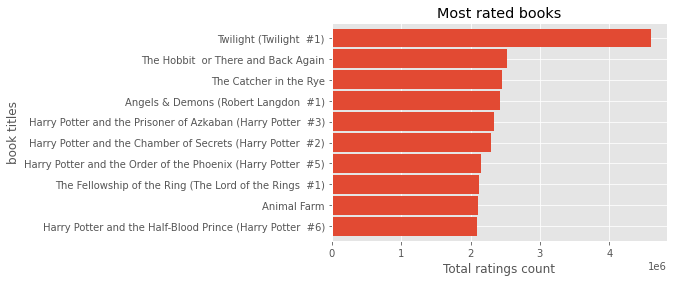

In [60]:
most_rated = df.sort_values('ratings_count',ascending=False).head(10).set_index('title')
ax = most_rated['ratings_count'].sort_values().plot.barh(width=0.9)
plt.ylabel('book titles')
plt.xlabel("Total ratings count")
plt.title("Most rated books")
plt.show()

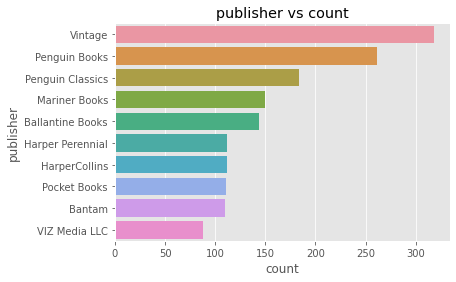

In [61]:
publ=df["publisher"].value_counts()[:10]
sns.barplot(x=publ,y=publ.index)
plt.title("publisher vs count")
plt.xlabel("count")
plt.ylabel("publisher")
plt.show()

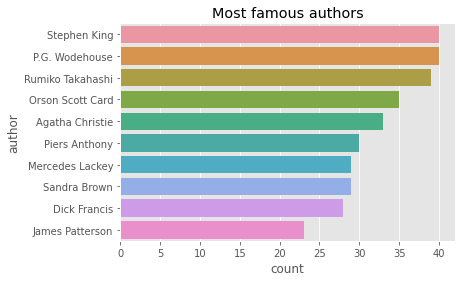

In [62]:
author=df["authors"].value_counts()[:10]
sns.barplot(x=author,y=author.index)
plt.title("Most famous authors")
plt.xlabel("count")
plt.ylabel("author")
plt.show()

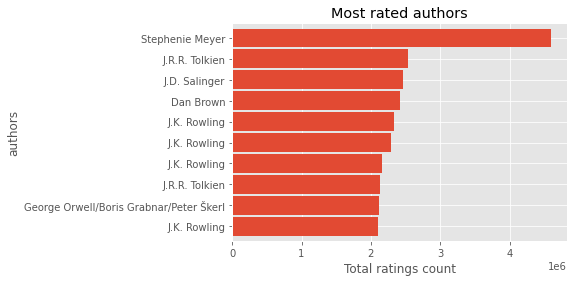

In [65]:
most_rated_authors = df.sort_values('ratings_count',ascending=False).head(10).set_index('authors')
ax = most_rated_authors['ratings_count'].sort_values().plot.barh(width=0.9)
plt.ylabel('authors')
plt.xlabel("Total ratings count")
plt.title("Most rated authors")
plt.show()

<Figure size 1080x720 with 0 Axes>

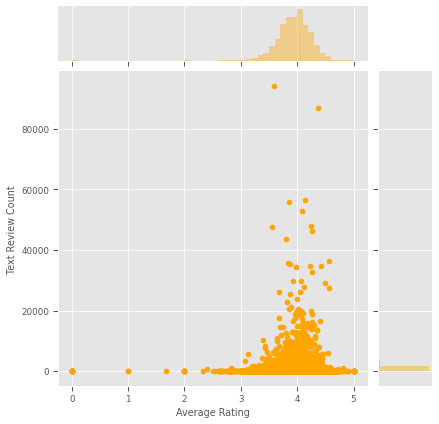

In [77]:
#relationship between ratings and review counts
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']],color = 'orange')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()

<Figure size 1080x720 with 0 Axes>

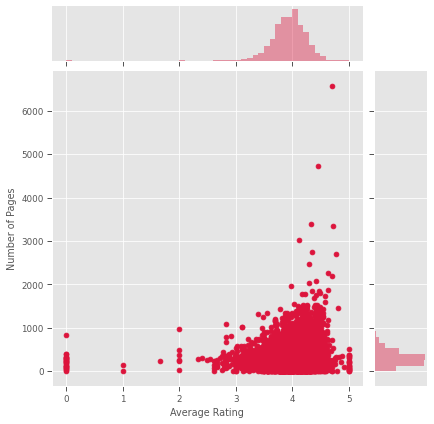

In [68]:
# relationship between average rating and no. of pages
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="  num_pages", data = df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")

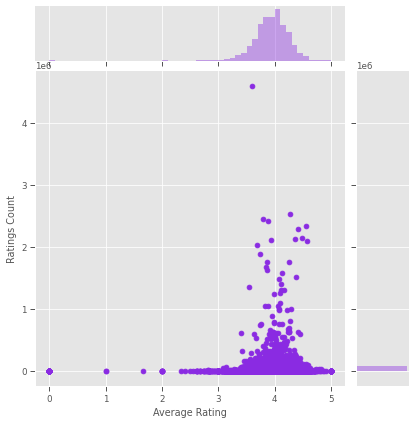

In [71]:
# relationship between average rating and rating counts
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")

there are many outliers present here

lets see after removing faraway outliers

In [72]:
trial = df[~(df.ratings_count>2000000)]

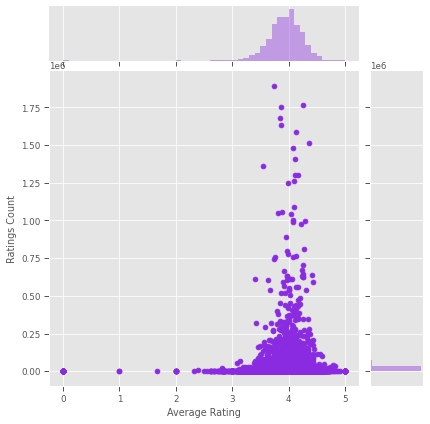

In [73]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")

this seems a better relationship than others

# K Means

In [97]:
trial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T

for finding best k value  **Elbow curve**

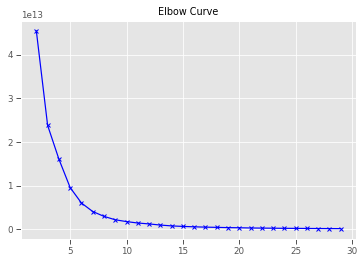

In [105]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")
plt.show()

In [79]:
centroids,_ = kmeans(data, 5)
idx, _ = vq(data, centroids)

In [80]:
trial.idxmax()

average_rating      624
ratings_count     10336
dtype: int64

In [ ]:
trial.drop(10336, inplace = True)

# Recommendation with KNN

> KNN comapares nearest neighbours and return them by calculating the distance between them

In [82]:
# seggregation function to classify books into broad 5 catgories based on average rating

def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [83]:
df['Ratings_Dist'] = segregation(df)

11123


In [84]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [85]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
0,0,0,0,0,1,4.57,2095690
1,0,0,0,0,1,4.49,2153167
2,0,0,0,0,1,4.42,6333
3,0,0,0,0,1,4.56,2339585
4,0,0,0,0,1,4.78,41428


minmax scaler to normalise the data and avoid baises caused by large numbers.

In [86]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

knn model for recommendation

In [87]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)

functions to get book names

In [125]:
# get similar books from book names

def get_index_from_name(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)
all_books_authors=list(df.authors.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
          ind=all_books_names.index(name)
          print(name,"|",ind,"|",df['authors'][df['title']==name].values)
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])
    # for i in l:
    #   df['average_rating'][df['title']==i]

In [89]:
# get similar books by author names

def get_index_from_authors(name):
    return df[df["authors"]==name].index.tolist()[0]

all_books_names = list(df.title.values)
all_books_authors=list(df.authors.values)

def get_id_from_partial_authors(partial):
    for name in all_books_authors:
      if partial in name:
        l=df["title"].loc[df['authors'] == name].values
    print(l)
            
def print_similar_authors(query=None,id=None):
    if id:
      for id in indices[id][1:]:
        print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_authors(query)
        for id in indices[found_id][1:]:
          print(df.iloc[id]["title"])

**Recommendations** 

In [128]:
df['title'][20]

'The Mother Tongue: English and How It Got That Way'

In [127]:
# similar books w.r.t partial name of the books
get_id_from_partial_name("Harry Potter")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) | 0 | ['J.K. Rowling' 'J.K. Rowling']
Harry Potter and the Order of the Phoenix (Harry Potter  #5) | 1 | ['J.K. Rowling']
Harry Potter and the Chamber of Secrets (Harry Potter  #2) | 2 | ['J.K. Rowling' 'J.K. Rowling']
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) | 3 | ['J.K. Rowling' 'J.K. Rowling']
Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5) | 4 | ['J.K. Rowling']
Unauthorized Harry Potter Book Seven News: "Half-Blood Prince" Analysis and Speculation | 5 | ['W. Frederick Zimmerman']
Harry Potter Collection (Harry Potter  #1-6) | 6 | ['J.K. Rowling']
Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry | 613 | ['J.K. Rowling']
J.K. Rowling's Harry Potter Novels: A Reader's Guide | 614 | ['Philip Nel']
Harry Potter and the Half-Blood Prince (Harry Potter  #6) | 0 | ['J.K. Rowling' 'J.K. Rowling']
Harry Potter Y La Piedra Filosofal (Harry Pott

In [126]:
# similar books w.r.t authors
print_similar_authors("J.K. Rowling")

Harry Potter and the Order of the Phoenix (Harry Potter  #5)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
The Lightning Thief (Percy Jackson and the Olympians  #1)


In [129]:
# similar books w.r.t books
print_similar_books("The Mother Tongue: English and How It Got That Way")

Marie Antoinette: The Journey
The End of Faith: Religion  Terror  and the Future of Reason
Rage of Angels
Cover Her Face (Adam Dalgliesh #1)
Quicksilver (The Baroque Cycle  #1)


In [94]:
# similar books w.r.t partial authors
get_id_from_partial_authors("J.K. Rowling")

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)'
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)'
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)'
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)'
 'Harry Potter Boxed Set  Books 1-5 (Harry Potter  #1-5)'
 'Harry Potter Collection (Harry Potter  #1-6)'
 'Harry Potter Schoolbooks Box Set: Two Classic Books from the Library of Hogwarts School of Witchcraft and Wizardry'
 'Harry Potter and the Half-Blood Prince (Harry Potter  #6)'
 'Harry Potter Y La Piedra Filosofal (Harry Potter  #1)'
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)'
 'Harry Potter y la Orden del Fénix (Harry Potter  #5)'
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)'
 "Harry Potter and the Sorcerer's Stone (Harry Potter  #1)"
 'Harry Potter und die Kammer des Schreckens (Harry Potter  #2)'
 'Harry Potter und der Gefangene von Askaban (Harry Potter  #3)'
 "Harry Potter and the Philosopher's 